In [81]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

%matplotlib inline

In [82]:
from sklearn.preprocessing import PowerTransformer, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score

In [83]:
# from google.colab import drive
# drive.mount('/gdrive')

In [84]:
# !cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
# !kaggle datasets download -d dev0914sharma/customer-clustering
# !unzip -q 'customer-clustering.zip'

# Dataset Download 



> **Source:**  [https://www.kaggle.com/datasets/dev0914sharma/customer-clustering?select=segmentation+data.csv](https://www.kaggle.com/datasets/dev0914sharma/customer-clustering?select=segmentation+data.csv)



> **Problem description:** There is data of supermarket membership cards with some basic data about customers like Customer ID, age, gender, annual income and spending score. Need to segment the customers for understanding which of them are target customers. The clustering results will be useful for the marketing team and the corresponding strategy planning.





In [85]:
data = pd.read_csv('/content/drive/MyDrive/DataSets/CustomerClustering/segmentation data.csv')

# Columns description

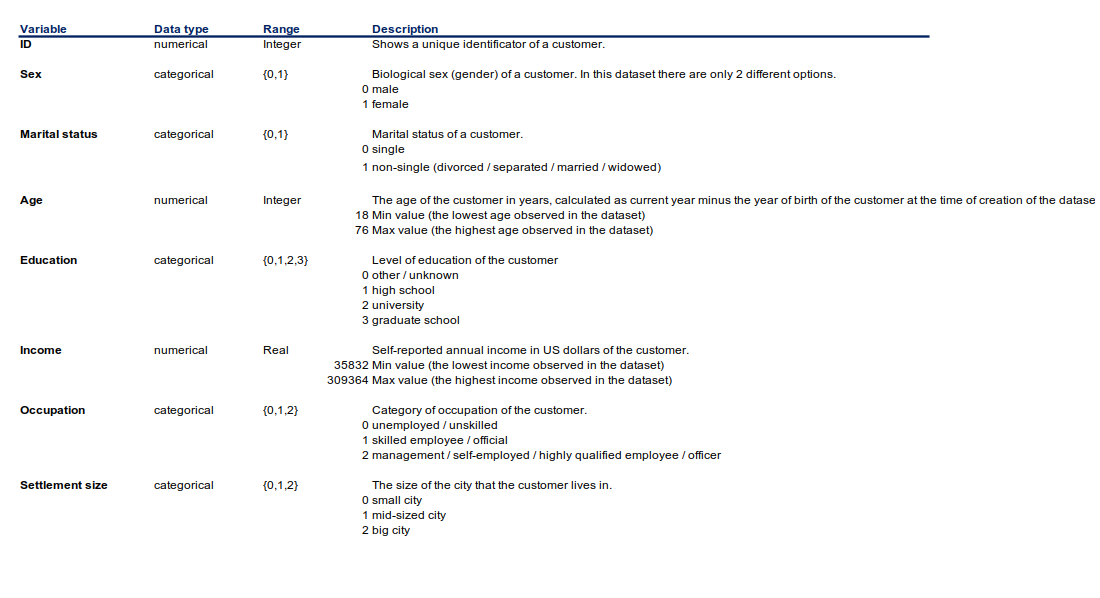

# Exploratory Data Analysis

In [86]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   ID               2000 non-null   int64
 1   Sex              2000 non-null   int64
 2   Marital status   2000 non-null   int64
 3   Age              2000 non-null   int64
 4   Education        2000 non-null   int64
 5   Income           2000 non-null   int64
 6   Occupation       2000 non-null   int64
 7   Settlement size  2000 non-null   int64
dtypes: int64(8)
memory usage: 125.1 KB


In [87]:
data.drop(columns = ['ID'], axis = 1, inplace=True)

In [88]:
# Data distripution
def get_histplot(data, title = 'Data distribution'):

    fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
    plt.subplots_adjust(hspace=0.5, wspace=0.4)
    fig.suptitle(title, fontsize=18, y=0.95)


    for column, ax in zip(data.columns, axs.ravel()[:data.shape[1]]):

        if column in ['Age', 'Income']:

            sns.kdeplot(data[column], color='green', shade = True, ax = ax)

        else:

            sns.histplot(data, x = column, color='#9966cc', ax = ax)
        
        ax.set_title(column.upper())
        ax.set_xlabel('')

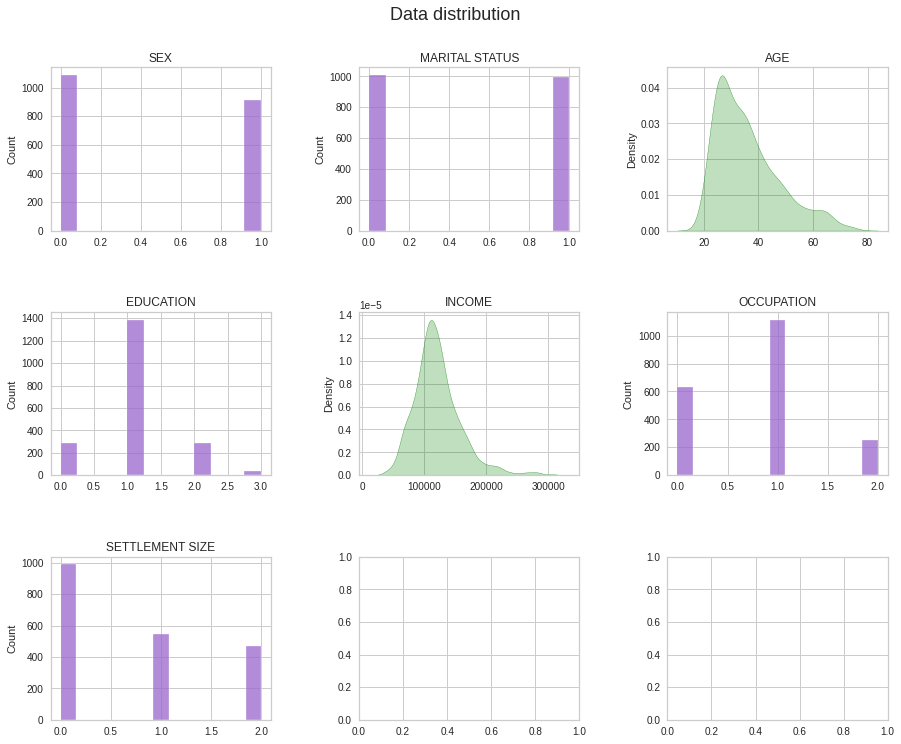

In [89]:
get_histplot(data = data)

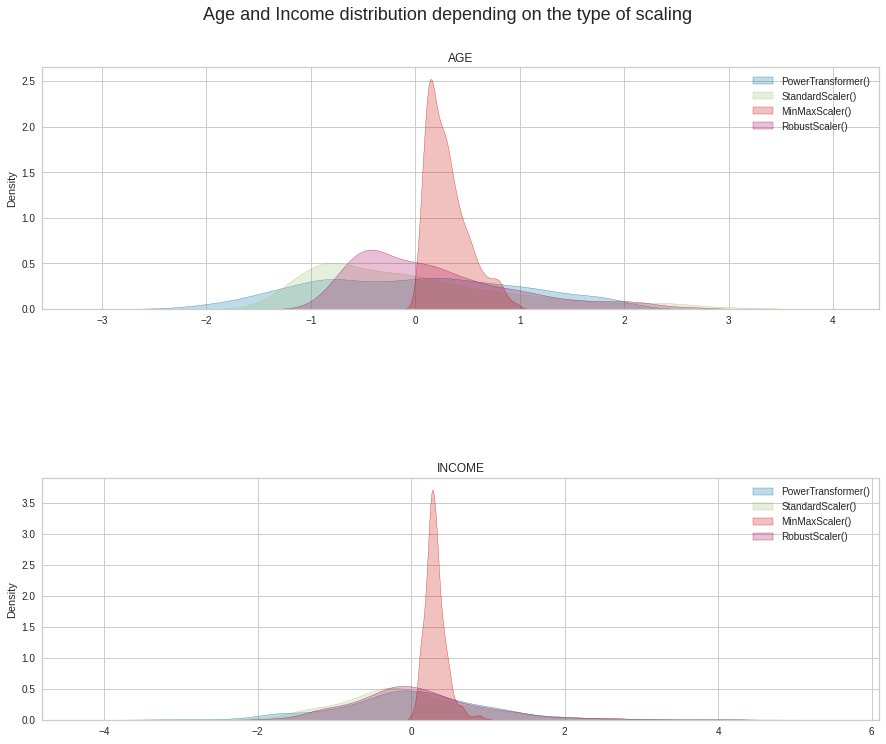

In [90]:
scalers = [PowerTransformer(),
           StandardScaler(),
           MinMaxScaler(),
           RobustScaler()]

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(15, 12))
plt.subplots_adjust(hspace=0.7, wspace=0.4)
fig.suptitle('Age and Income distribution depending on the type of scaling', fontsize=18, y=0.95)
ax = axs.ravel()

for scaler in scalers:

    scaler_name = str(scaler)
    data_scaled = scaler.fit_transform(data[['Age', 'Income']])

    # histplot 
    sns.kdeplot(data_scaled[:,0], label = scaler_name, shade = True, ax = ax[0])
    sns.kdeplot(data_scaled[:,1], label = scaler_name, shade = True, ax = ax[1])

ax[0].set_title('AGE')
ax[0].legend()

ax[1].set_title('INCOME')
ax[1].legend()

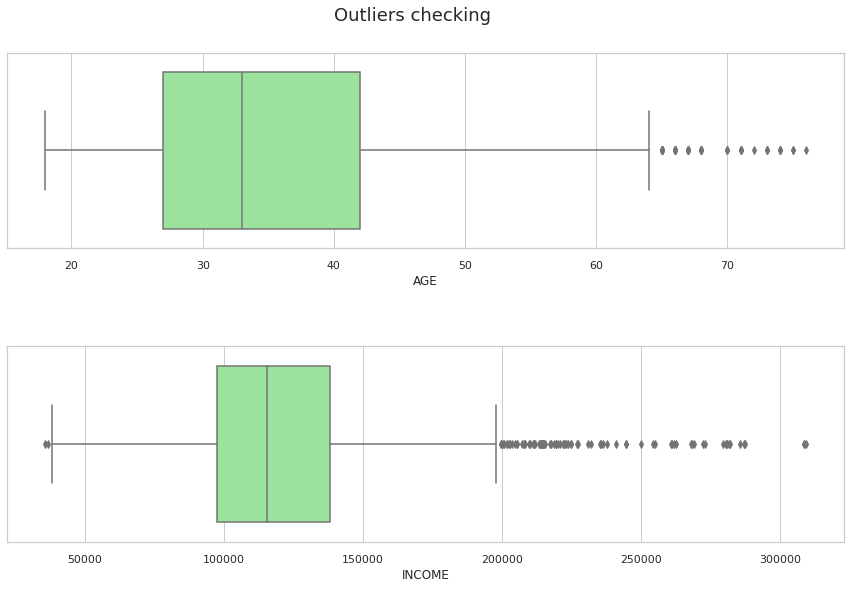

In [91]:
sns.set(style="whitegrid")
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(15, 9))
plt.subplots_adjust(hspace=0.5, wspace=0.4)
fig.suptitle('Outliers checking', fontsize=18, y=0.95)
ax = axs.ravel()

for column, ax in zip(['Age', 'Income'], ax):

    sns.boxplot(x=data[column], orient='h', color='#90ee90', ax = ax)
    ax.set_xlabel(ax.get_xlabel().upper())


In [92]:
q = data[['Age', 'Income']].quantile(q = [.25, .75])

IQR = q.loc[0.75] - q.loc[0.25]

low_border = q.loc[0.25] - 1.5*IQR
high_border = q.loc[0.75] + 1.5*IQR

income_low_outlier = data[data.Income < low_border.Income][['Income', 'Age']]
income_high_outlier = data[data.Income > high_border.Income][['Income', 'Age']]
age_high_outlier = data[data.Age > high_border.Age][['Age', 'Income']]

Text(0.5, 0, 'AGE')

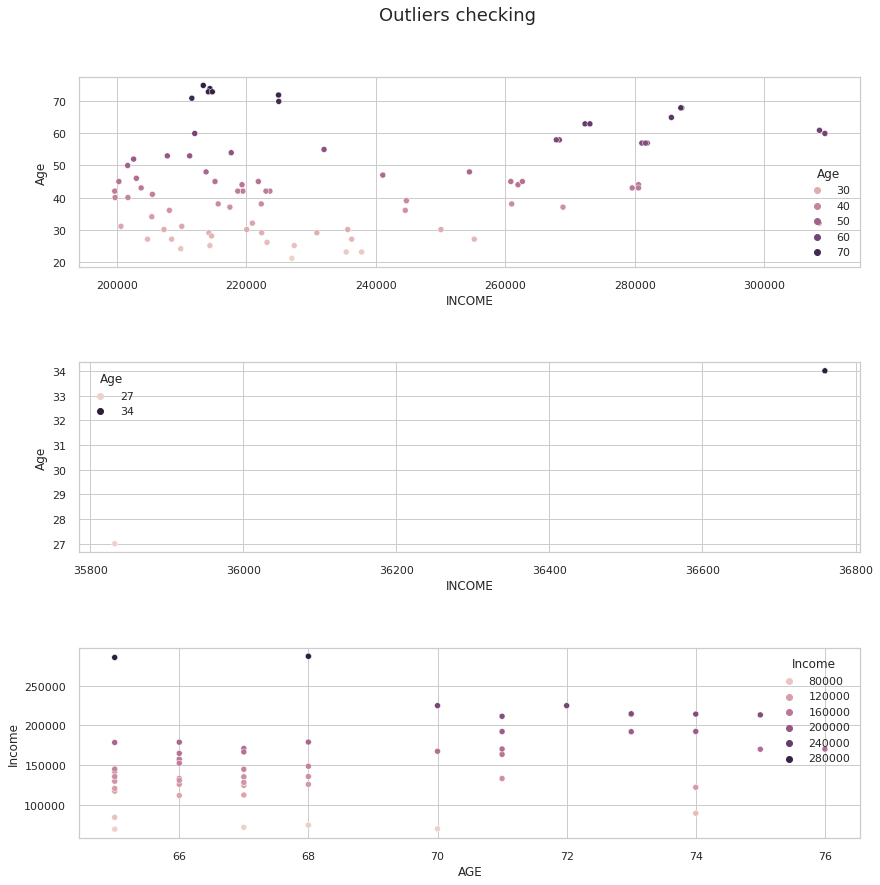

In [93]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(14, 14))
plt.subplots_adjust(hspace=0.5, wspace=0.4)
fig.suptitle('Outliers checking', fontsize=18, y=0.95)
ax = axs.ravel()

sns.scatterplot(data = income_high_outlier, x = 'Income', y = 'Age', hue = 'Age', ax = ax[0])
sns.scatterplot(data = income_low_outlier, x = 'Income', y = 'Age', hue = 'Age', ax = ax[1])
sns.scatterplot(data = age_high_outlier, x = 'Age', y = 'Income', hue = 'Income', ax = ax[2])

ax[0].set_xlabel(ax[0].get_xlabel().upper())
ax[1].set_xlabel(ax[1].get_xlabel().upper())
ax[2].set_xlabel(ax[2].get_xlabel().upper())

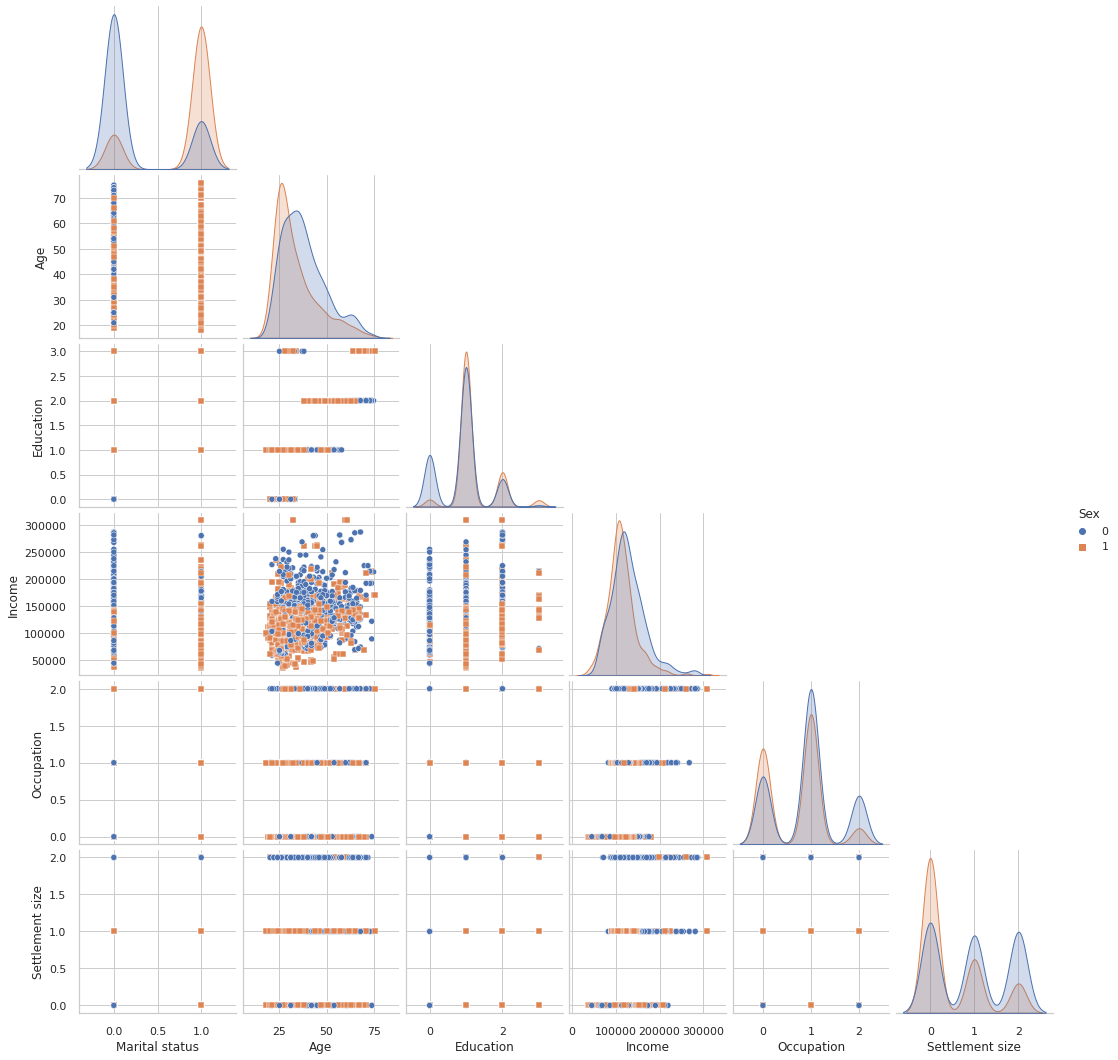

In [94]:
sns.pairplot(data, hue='Sex', markers=['o', 's'], corner = True)

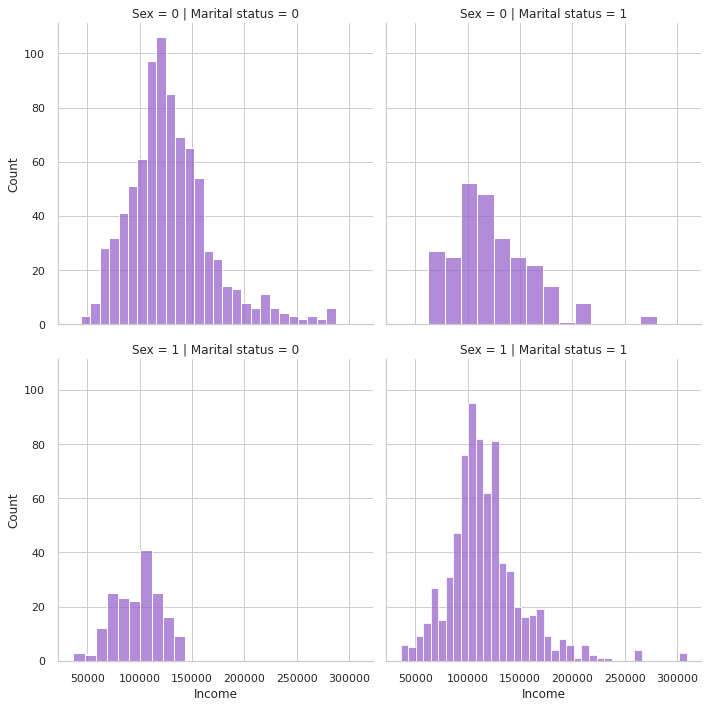

In [95]:
g = sns.FacetGrid(data, col='Marital status',  row='Sex', height=5)
g.map_dataframe(sns.histplot, x='Income', color='#9966cc')

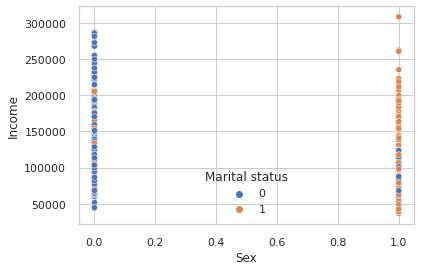

In [96]:
sns.scatterplot(x = data['Sex'], y = data['Income'], hue = data['Marital status'])

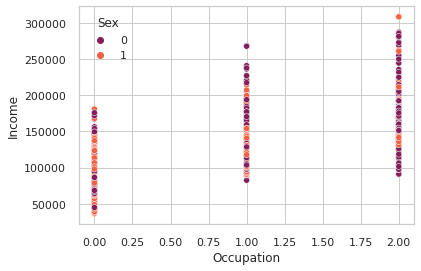

In [97]:
sns.scatterplot(x = data['Occupation'], y = data['Income'], hue = data['Sex'], palette = 'rocket')

# Data Preprocessing

In [98]:
to_scale = ['Age', 'Income']
scaling_pipe = make_pipeline(StandardScaler())

preprocessor = ColumnTransformer(transformers=[
    ('standardization', scaling_pipe, to_scale)
])

columns_scaled = preprocessor.fit_transform(data)

In [99]:
scaled_data = data.copy()
scaled_data[['Age', 'Income']] = columns_scaled

In [100]:
scaled_data.describe()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
count,2000.000000,2000.000000,2.000000e+03,2000.00000,2.000000e+03,2000.000000,2000.000000
mean,0.457000,0.496500,9.059420e-17,1.03800,1.563194e-16,0.810500,0.739000
std,0.498272,0.500113,1.000250e+00,0.59978,1.000250e+00,0.638587,0.812533
min,0.000000,0.000000,-1.528532e+00,0.00000,-2.234225e+00,0.000000,0.000000
25%,0.000000,0.000000,-7.603825e-01,1.00000,-6.113281e-01,0.000000,0.000000
50%,0.000000,0.000000,-2.482829e-01,1.00000,-1.418903e-01,1.000000,1.000000
75%,1.000000,1.000000,5.198664e-01,1.00000,4.492952e-01,1.000000,1.000000
max,1.000000,1.000000,3.421764e+00,3.00000,4.945225e+00,2.000000,2.000000




> Creating an empty DataFrame to record the results of the algorithms



In [101]:
results = pd.DataFrame()

# K-Means++



> Identifying k - number of clusters using 'Elbow method'



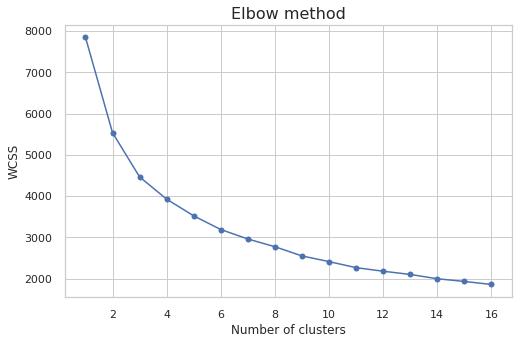

In [102]:
WCSS = []

for count in range(1, 17):

    kmeans_model = KMeans(n_clusters = count, init = 'k-means++', random_state = 43)
    kmeans_model.fit(scaled_data)

    WCSS.append(kmeans_model.inertia_)


fig = plt.figure(figsize = (8, 5))

plt.plot(range(1, 17), WCSS, marker = 'o')
plt.title('Elbow method', fontsize = 16)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

plt.show()

In [103]:
!pip install kneed

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [104]:
from kneed import KneeLocator

knee = KneeLocator(range(1, 17), WCSS, curve = 'convex', direction = 'decreasing' )
knee.elbow

5

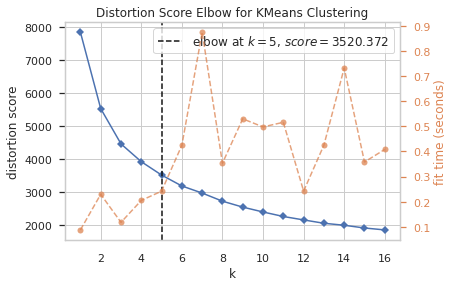

In [105]:
from yellowbrick.cluster import KElbowVisualizer

visualizer = KElbowVisualizer(KMeans(), k = (1, 17))
visualizer.fit(scaled_data)
visualizer.show()



> Fitting the K-Means++ model with 5 clusters



In [106]:
kmeans_model = KMeans(n_clusters = 5, init = 'k-means++', random_state = 43)
kmeans_model.fit(scaled_data)

KMeans(n_clusters=5, random_state=43)

In [107]:
kmeans_model.labels_

array([2, 4, 2, ..., 0, 0, 0], dtype=int32)



> Writing the results



In [108]:
results['Kmeans++, k = 5'] = kmeans_model.labels_

In [109]:
results.head()

,"Kmeans++, k = 5"
0,2
1,4
2,2
3,3
4,2


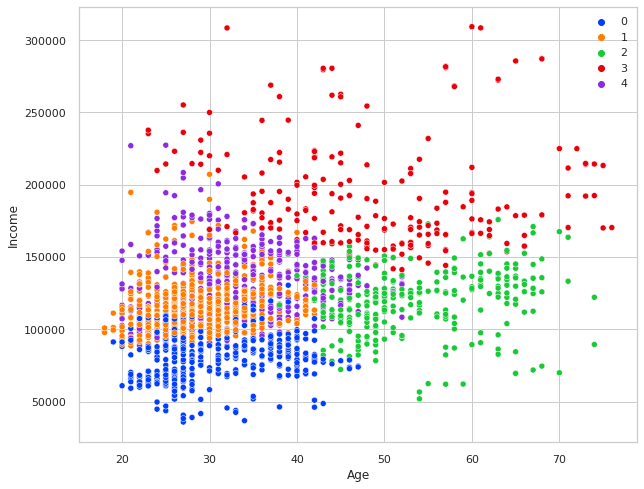

In [110]:
fig = plt.figure(figsize = (10, 8))

sns.scatterplot(x = data['Age'], y = data['Income'], hue = kmeans_model.labels_, palette = 'bright')

plt.show()

In [111]:
merge_df = pd.concat([data, results['Kmeans++, k = 5']], axis = 1)

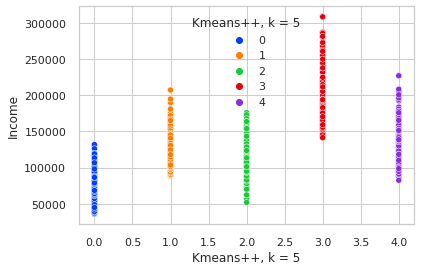

In [112]:
sns.scatterplot(x = merge_df['Kmeans++, k = 5'], y = merge_df['Income'], hue = merge_df['Kmeans++, k = 5'], palette = 'bright')

In [113]:
print(f'Algorithm : KMeans++' + '\n' +
      f'N_clusters : {kmeans_model.n_clusters}' + '\n' +
      f'Silhouette Coefficient : {silhouette_score(data, kmeans_model.labels_)}')

Algorithm : KMeans++
N_clusters : 5
Silhouette Coefficient : 0.07003648187599569


# Agglomerative hierarchical clustering



> Using the dendrogram to find the optimal number of clusters



In [114]:
from scipy.cluster import hierarchy

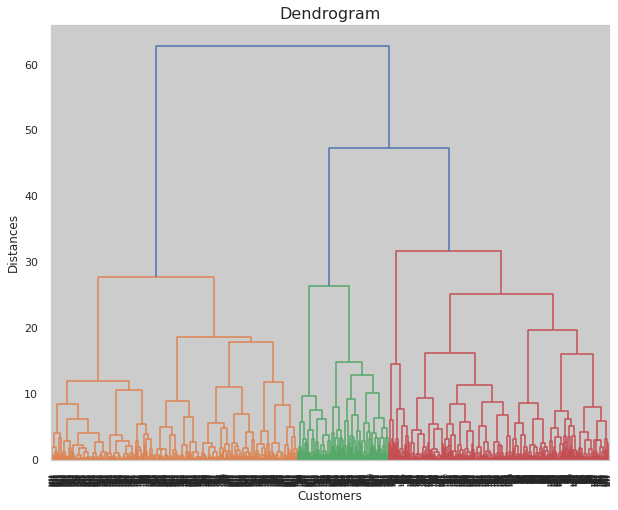

In [115]:
plt.figure(figsize = (10, 8))

dendrogram = hierarchy.dendrogram(hierarchy.linkage(scaled_data, method = 'ward'))

plt.title('Dendrogram', fontsize = 16)
plt.xlabel('Customers')
plt.ylabel('Distances')

plt.show()



> Training the model om the dataset



In [116]:
ahc = AgglomerativeClustering(n_clusters = 5, affinity = 'euclidean', linkage = 'ward')
ahc.fit(scaled_data)
ahc_predict = ahc.labels_

In [117]:
results['AggHierachicalCl, k = 5'] = ahc_predict

In [118]:
results.head()

,"Kmeans++, k = 5","AggHierachicalCl, k = 5"
0,2,0
1,4,1
2,2,2
3,3,1
4,2,1


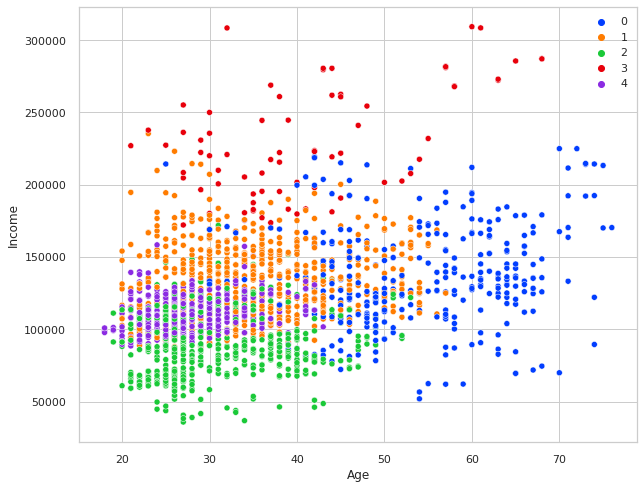

In [119]:
fig = plt.figure(figsize = (10, 8))

sns.scatterplot(x = data['Age'], y = data['Income'], hue = ahc_predict, palette = 'bright')

plt.show()

In [120]:
print(f'Algorithm : Agglomerative Hierarchical' + '\n' +
      f'N_clusters : {ahc.n_clusters}' + '\n' +
      f'Silhouette Coefficient : {silhouette_score(data, ahc.labels_)}')

Algorithm : Agglomerative Hierarchical
N_clusters : 5
Silhouette Coefficient : -0.01571187248992452
